In [1]:
!pip install Backtesting

  Created wheel for Backtesting: filename=Backtesting-0.2.1-py3-none-any.whl size=168643 sha256=b04818f290254d772336f27cb001276c70faf63b8a4c691e6c00959fa566efcd
  Stored in directory: c:\users\tempurak\appdata\local\pip\cache\wheels\0e\32\ba\99dea619caf15b6049284f24cedd667306a28d5746882a4bbc
Successfully built Backtesting


In [2]:
import MetaTrader5 as mt5

In [27]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

from backtesting.test import SMA, GOOG, EURUSD


class SmaCross(Strategy):
    def init(self):
        price = self.data.Close
        self.ma1 = self.I(SMA, price, 10)
        self.ma2 = self.I(SMA, price, 20)

    def next(self):
        if crossover(self.ma1, self.ma2):
            self.buy()
        elif crossover(self.ma2, self.ma1):
            self.sell()


bt = Backtest(EURUSD, SmaCross, commission=.002,
              exclusive_orders=True)
stats = bt.run()
bt.plot()

In [9]:
import pandas
from datetime import datetime

In [7]:
mt5.initialize()

utc_from = datetime(2020, 6, 9) 

AUDUSD = mt5.copy_rates_from('AUDUSDm', mt5.TIMEFRAME_D1, utc_from, 10000)

In [11]:
GOOG

Open    High     Low   Close    Volume
2004-08-19  100.00  104.06   95.96  100.34  22351900
2004-08-20  101.01  109.08  100.50  108.31  11428600
2004-08-23  110.75  113.48  109.05  109.40   9137200
2004-08-24  111.24  111.60  103.57  104.87   7631300
2004-08-25  104.96  108.00  103.88  106.00   4598900
...            ...     ...     ...     ...       ...
2013-02-25  802.30  808.41  790.49  790.77   2303900
2013-02-26  795.00  795.95  784.40  790.13   2202500
2013-02-27  794.80  804.75  791.11  799.78   2026100
2013-02-28  801.10  806.99  801.03  801.20   2265800
2013-03-01  797.80  807.14  796.15  806.19   2175400

[2148 rows x 5 columns]

In [37]:
import talib

In [13]:
AUDUSD = pandas.DataFrame(AUDUSD)

In [15]:
AUDUSD.columns = ['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume', 'Spread', 'Real_Volume']

In [22]:
AUDUSD = AUDUSD.set_index(AUDUSD['Datetime'].apply(datetime.fromtimestamp))

In [33]:
AUDUSD['momentum'] = AUDUSD['Close'].pct_change(10)

In [235]:
AUDUSD['upperband'], AUDUSD['middleband'], AUDUSD['lowerband']  = talib.BBANDS(AUDUSD['Close'], timeperiod=5, nbdevup=3, nbdevdn=3, matype=0)

In [236]:
AUDUSD['upperband']  = AUDUSD['upperband'].shift(1)
AUDUSD['middleband'] = AUDUSD['middleband'].shift(1)
AUDUSD['lowerband']  = AUDUSD['lowerband'].shift(1)

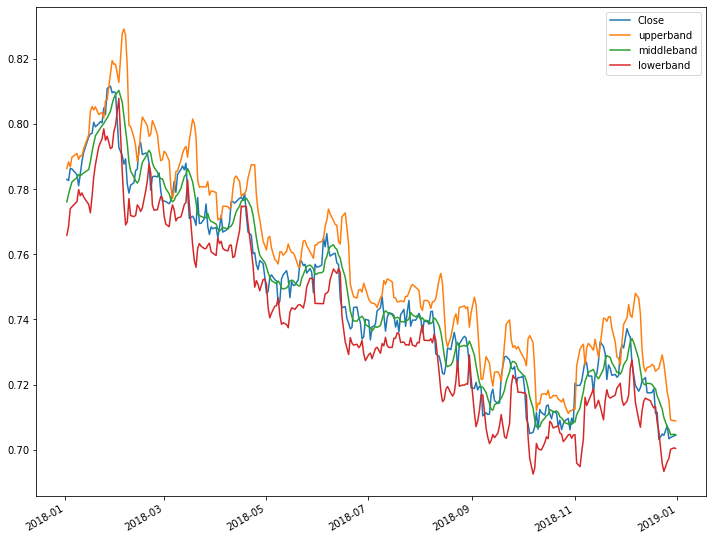

In [237]:
AUDUSD[['Close', 'upperband', 'middleband', 'lowerband']]['2018'].plot(figsize=(12, 10))

In [238]:
AUDUSD['signal_buy']       = (AUDUSD['Close'] < AUDUSD['lowerband']).astype(int)
AUDUSD['signal_close_buy'] = (AUDUSD['Close'] > AUDUSD['middleband']).astype(int)

AUDUSD['signal_sell']       = (AUDUSD['Close'] > AUDUSD['upperband']).astype(int)
AUDUSD['signal_close_sell'] = (AUDUSD['Close'] < AUDUSD['middleband']).astype(int)

AUDUSD['signal_long']  = 0
AUDUSD['signal_short'] = 0 

In [239]:
position_long = False
for index, row in AUDUSD.iterrows():
    
    if position_long and row['signal_close_buy']:
        AUDUSD.loc[index, 'signal_long'] = 0
        position_long = False
        continue
    
    if not position_long and row['signal_buy']:
        AUDUSD.loc[index, 'signal_long'] = 1
        position_long = True
        continue
    
    if position_long:
        AUDUSD.loc[index, 'signal_long'] = 1

In [240]:
position_short = False
for index, row in AUDUSD.iterrows():
    
    if position_short and row['signal_close_sell']:
        AUDUSD.loc[index, 'signal_short'] = 0
        position_short = False
        continue
    
    if not position_short and row['signal_sell']:
        AUDUSD.loc[index, 'signal_short'] = -1
        position_short = True
        continue
    
    if position_short:
        AUDUSD.loc[index, 'signal_short'] = -1

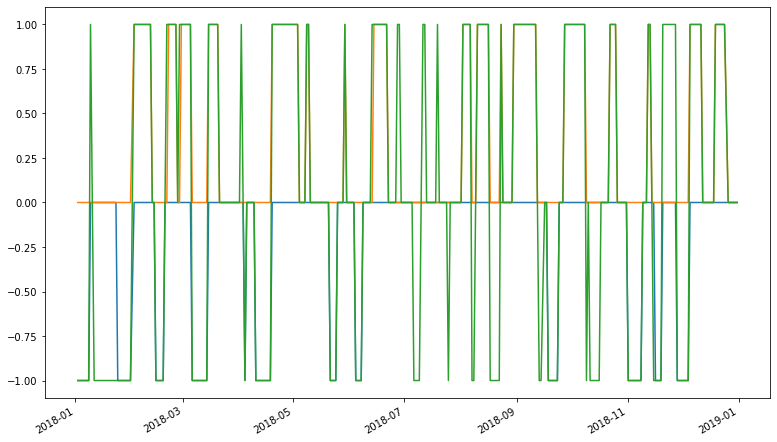

In [241]:
AUDUSD['2018']['signal_short'].plot(figsize=(13, 8))
AUDUSD['2018']['signal_long'].plot()
AUDUSD['2018']['signal'].plot()

In [242]:
AUDUSD['signal'] = AUDUSD['signal_long'] + AUDUSD['signal_short']

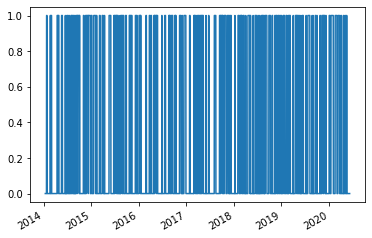

In [219]:
AUDUSD['signal_long'].plot()

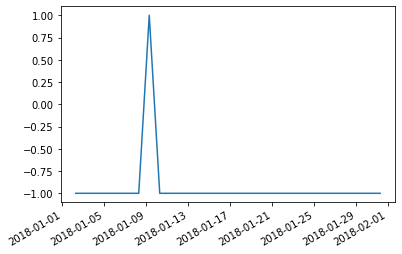

In [113]:
(AUDUSD['signal_buy'] + AUDUSD['signal_close_buy'])['2018-01'].plot()

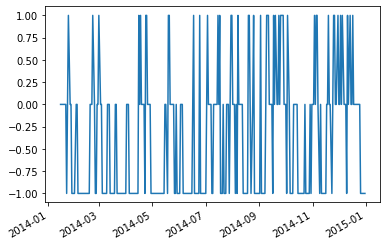

In [134]:
((AUDUSD['signal_buy'] + AUDUSD['signal_close_buy'])['2014'].diff()).cumsum().plot()

In [136]:
mean_reverse = (AUDUSD['signal_buy'] + AUDUSD['signal_close_buy'])

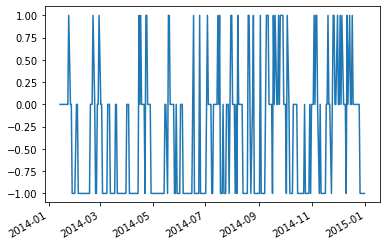

In [139]:
trigger_buy = False

for index, signal in mean_reverse.iteritems():
    if signal <= 0:
        mean_reverse.at[index] = 0
    else:
        break

mean_reverse['2014'].plot()

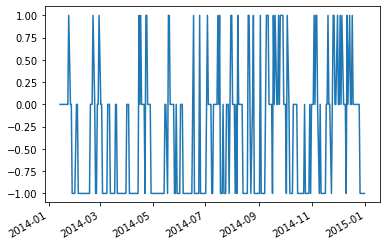

In [172]:
mean_reverse['2014'].plot()

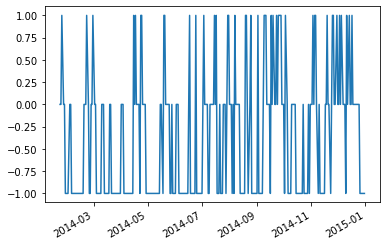

In [179]:
mean_reverse['2014'].diff().cumsum().diff().cumsum().diff().cumsum().diff().cumsum().diff().cumsum().diff().cumsum().diff().cumsum().plot()

In [150]:
AUDUSD['signal_long'] = (mean_reverse.diff().cumsum() > 0).astype(int)

KeyError: "None of [Int64Index([ 0,  0,  0,  0,  0,  0,  0, -1,  0,  1,\n            ...\n            -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],\n           dtype='int64', length=1954)] are in the [columns]"

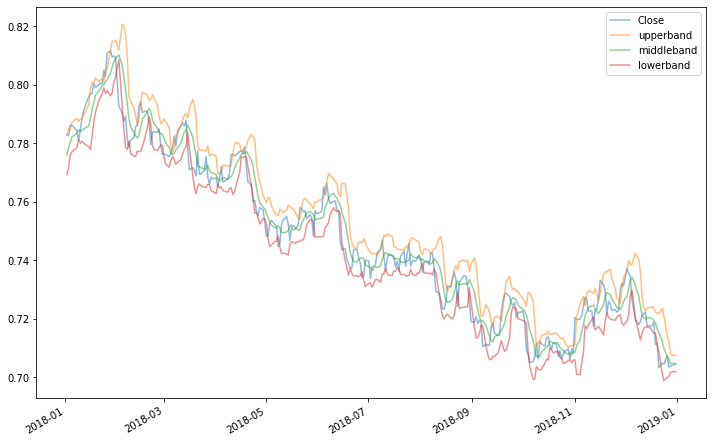

In [229]:
AUDUSD[['Close', 'upperband', 'middleband', 'lowerband']]['2018'].plot(figsize=(12, 8), alpha=0.5)
(AUDUSD[AUDUSD['signal']]['2018'] * AUDUSD['Close']['2018']).plot(figsize=(12, 8), alpha=1, linewidth=0, marker='o')

In [200]:
import matplotlib.pyplot as plt

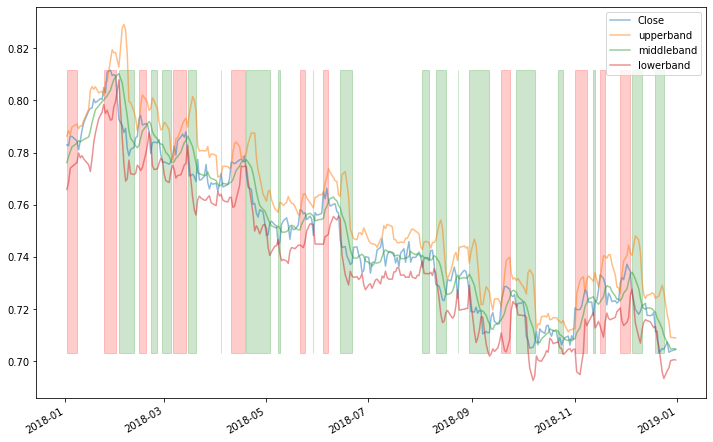

In [244]:
AUDUSD[['Close', 'upperband', 'middleband', 'lowerband']]['2018'].plot(figsize=(12, 8), alpha=0.5)
plt.fill_between(AUDUSD['2018'].index, AUDUSD['2018']['Close'].min(), AUDUSD['2018']['Close'].max(), where=AUDUSD['2018']['signal'] > 0, color='g', alpha=0.2)
plt.fill_between(AUDUSD['2018'].index, AUDUSD['2018']['Close'].min(), AUDUSD['2018']['Close'].max(), where=AUDUSD['2018']['signal'] < 0, color='r', alpha=0.2)

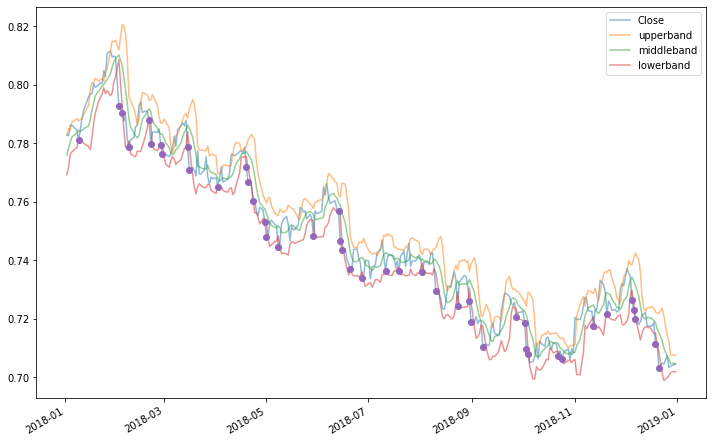

In [197]:
AUDUSD[['Close', 'upperband', 'middleband', 'lowerband']]['2018'].plot(figsize=(12, 8), alpha=0.5)
(AUDUSD[AUDUSD['signal_long'] > 0]['signal_long']['2018'] * AUDUSD['Close']['2018']).plot(figsize=(12, 8), alpha=1, linewidth=0, marker='o')

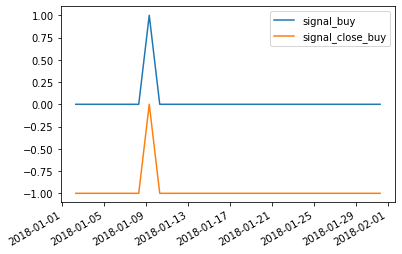

In [111]:
AUDUSD[['signal_buy', 'signal_close_buy']]['2018-01'].plot()

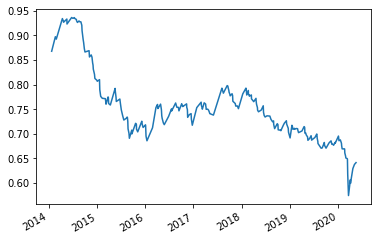

In [100]:
AUDUSD[AUDUSD['signal_buy'] == 1]['Close'].plot()

In [80]:
class MeanReverseBolinger(Strategy):
    
    def init(self):
        self.price = self.data.Close
        self.upperband  = self.data.upperband
        self.middleband = self.data.middleband
        self.lowerband  = self.data.lowerband
        self.ma1 = self.I(SMA, self.price, 10)
        self.ma2 = self.I(SMA, self.price, 20)

    def next(self):
        
        if not self.position.is_long:
            print('no long position')
            print(len(self.price), self.ma2)
            if self.price <= self.middleband:
                print('buy')
                self.buy()

bt = Backtest(AUDUSD.dropna(), MeanReverseBolinger, commission=.002,
              exclusive_orders=True)
stats = bt.run()
bt.plot()

no long position
1944 [      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan 0.8887975 0.8904105]
no long position
1944 [      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan 0.8887975 0.8904105
 0.8917265]
no long position
1944 [      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan 0.8887975 0.8904105
 0.8917265 0.8928495]
no long position
1944 [      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan 0.8887975 0.8904105
 0.8917265 0.8928495 0.89

 0.9307415 0.931271 ]
no long position
1944 [      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan 0.8887975 0.8904105
 0.8917265 0.8928495 0.893981  0.894892  0.896315  0.8975995 0.8986725
 0.898922  0.8989155 0.898696  0.898537  0.898603  0.898761  0.899186
 0.899412  0.899771  0.8997335 0.899259  0.8990545 0.8991095 0.899286
 0.899384  0.8999355 0.9007015 0.9006635 0.90079   0.9013535 0.902018
 0.903027  0.904319  0.9058065 0.907364  0.908698  0.909471  0.9104755
 0.9113905 0.912515  0.913859  0.9153155 0.916619  0.917797  0.9193895
 0.9208495 0.9221805 0.924005  0.9257455 0.9274255 0.928671  0.929901
 0.9307415 0.931271  0.931589 ]
no long position
1944 [      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan 0.8

1944 [      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan 0.8887975 0.8904105
 0.8917265 0.8928495 0.893981  0.894892  0.896315  0.8975995 0.8986725
 0.898922  0.8989155 0.898696  0.898537  0.898603  0.898761  0.899186
 0.899412  0.899771  0.8997335 0.899259  0.8990545 0.8991095 0.899286
 0.899384  0.8999355 0.9007015 0.9006635 0.90079   0.9013535 0.902018
 0.903027  0.904319  0.9058065 0.907364  0.908698  0.909471  0.9104755
 0.9113905 0.912515  0.913859  0.9153155 0.916619  0.917797  0.9193895
 0.9208495 0.9221805 0.924005  0.9257455 0.9274255 0.928671  0.929901
 0.9307415 0.931271  0.931589  0.9320525 0.932611  0.9327075 0.932863
 0.932983  0.933181  0.933003  0.932926  0.9330085 0.9326405 0.932139
 0.9315255 0.930973  0.930793  0.93035   0.930484  0.9304265 0.930566
 0.930717 ]
no long position
1944 [      nan       nan       nan       nan     

1944 [      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan 0.8887975 0.8904105
 0.8917265 0.8928495 0.893981  0.894892  0.896315  0.8975995 0.8986725
 0.898922  0.8989155 0.898696  0.898537  0.898603  0.898761  0.899186
 0.899412  0.899771  0.8997335 0.899259  0.8990545 0.8991095 0.899286
 0.899384  0.8999355 0.9007015 0.9006635 0.90079   0.9013535 0.902018
 0.903027  0.904319  0.9058065 0.907364  0.908698  0.909471  0.9104755
 0.9113905 0.912515  0.913859  0.9153155 0.916619  0.917797  0.9193895
 0.9208495 0.9221805 0.924005  0.9257455 0.9274255 0.928671  0.929901
 0.9307415 0.931271  0.931589  0.9320525 0.932611  0.9327075 0.932863
 0.932983  0.933181  0.933003  0.932926  0.9330085 0.9326405 0.932139
 0.9315255 0.930973  0.930793  0.93035   0.930484  0.9304265 0.930566
 0.930717  0.930871  0.9310285 0.9309555 0.931313  0.931797  0.93211
 0.931908 

1944 [      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan 0.8887975 0.8904105
 0.8917265 0.8928495 0.893981  0.894892  0.896315  0.8975995 0.8986725
 0.898922  0.8989155 0.898696  0.898537  0.898603  0.898761  0.899186
 0.899412  0.899771  0.8997335 0.899259  0.8990545 0.8991095 0.899286
 0.899384  0.8999355 0.9007015 0.9006635 0.90079   0.9013535 0.902018
 0.903027  0.904319  0.9058065 0.907364  0.908698  0.909471  0.9104755
 0.9113905 0.912515  0.913859  0.9153155 0.916619  0.917797  0.9193895
 0.9208495 0.9221805 0.924005  0.9257455 0.9274255 0.928671  0.929901
 0.9307415 0.931271  0.931589  0.9320525 0.932611  0.9327075 0.932863
 0.932983  0.933181  0.933003  0.932926  0.9330085 0.9326405 0.932139
 0.9315255 0.930973  0.930793  0.93035   0.930484  0.9304265 0.930566
 0.930717  0.930871  0.9310285 0.9309555 0.931313  0.931797  0.93211
 0.931908 

1944 [      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan 0.8887975 0.8904105
 0.8917265 0.8928495 0.893981  0.894892  0.896315  0.8975995 0.8986725
 0.898922  0.8989155 0.898696  0.898537  0.898603  0.898761  0.899186
 0.899412  0.899771  0.8997335 0.899259  0.8990545 0.8991095 0.899286
 0.899384  0.8999355 0.9007015 0.9006635 0.90079   0.9013535 0.902018
 0.903027  0.904319  0.9058065 0.907364  0.908698  0.909471  0.9104755
 0.9113905 0.912515  0.913859  0.9153155 0.916619  0.917797  0.9193895
 0.9208495 0.9221805 0.924005  0.9257455 0.9274255 0.928671  0.929901
 0.9307415 0.931271  0.931589  0.9320525 0.932611  0.9327075 0.932863
 0.932983  0.933181  0.933003  0.932926  0.9330085 0.9326405 0.932139
 0.9315255 0.930973  0.930793  0.93035   0.930484  0.9304265 0.930566
 0.930717  0.930871  0.9310285 0.9309555 0.931313  0.931797  0.93211
 0.931908 

1944 [      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan 0.8887975 0.8904105
 0.8917265 0.8928495 0.893981  0.894892  0.896315  0.8975995 0.8986725
 0.898922  0.8989155 0.898696  0.898537  0.898603  0.898761  0.899186
 0.899412  0.899771  0.8997335 0.899259  0.8990545 0.8991095 0.899286
 0.899384  0.8999355 0.9007015 0.9006635 0.90079   0.9013535 0.902018
 0.903027  0.904319  0.9058065 0.907364  0.908698  0.909471  0.9104755
 0.9113905 0.912515  0.913859  0.9153155 0.916619  0.917797  0.9193895
 0.9208495 0.9221805 0.924005  0.9257455 0.9274255 0.928671  0.929901
 0.9307415 0.931271  0.931589  0.9320525 0.932611  0.9327075 0.932863
 0.932983  0.933181  0.933003  0.932926  0.9330085 0.9326405 0.932139
 0.9315255 0.930973  0.930793  0.93035   0.930484  0.9304265 0.930566
 0.930717  0.930871  0.9310285 0.9309555 0.931313  0.931797  0.93211
 0.931908 

 0.7934405 0.7930105 0.792893  0.7924825 0.7919685 0.790605  0.7890405]
no long position
1944 [      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan 0.8887975 0.8904105
 0.8917265 0.8928495 0.893981  0.894892  0.896315  0.8975995 0.8986725
 0.898922  0.8989155 0.898696  0.898537  0.898603  0.898761  0.899186
 0.899412  0.899771  0.8997335 0.899259  0.8990545 0.8991095 0.899286
 0.899384  0.8999355 0.9007015 0.9006635 0.90079   0.9013535 0.902018
 0.903027  0.904319  0.9058065 0.907364  0.908698  0.909471  0.9104755
 0.9113905 0.912515  0.913859  0.9153155 0.916619  0.917797  0.9193895
 0.9208495 0.9221805 0.924005  0.9257455 0.9274255 0.928671  0.929901
 0.9307415 0.931271  0.931589  0.9320525 0.932611  0.9327075 0.932863
 0.932983  0.933181  0.933003  0.932926  0.9330085 0.9326405 0.932139
 0.9315255 0.930973  0.930793  0.93035   0.930484  0.9304265

1944 [      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan 0.8887975 0.8904105
 0.8917265 0.8928495 0.893981  0.894892  0.896315  0.8975995 0.8986725
 0.898922  0.8989155 0.898696  0.898537  0.898603  0.898761  0.899186
 0.899412  0.899771  0.8997335 0.899259  0.8990545 0.8991095 0.899286
 0.899384  0.8999355 0.9007015 0.9006635 0.90079   0.9013535 0.902018
 0.903027  0.904319  0.9058065 0.907364  0.908698  0.909471  0.9104755
 0.9113905 0.912515  0.913859  0.9153155 0.916619  0.917797  0.9193895
 0.9208495 0.9221805 0.924005  0.9257455 0.9274255 0.928671  0.929901
 0.9307415 0.931271  0.931589  0.9320525 0.932611  0.9327075 0.932863
 0.932983  0.933181  0.933003  0.932926  0.9330085 0.9326405 0.932139
 0.9315255 0.930973  0.930793  0.93035   0.930484  0.9304265 0.930566
 0.930717  0.930871  0.9310285 0.9309555 0.931313  0.931797  0.93211
 0.931908 

1944 [      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan 0.8887975 0.8904105
 0.8917265 0.8928495 0.893981  0.894892  0.896315  0.8975995 0.8986725
 0.898922  0.8989155 0.898696  0.898537  0.898603  0.898761  0.899186
 0.899412  0.899771  0.8997335 0.899259  0.8990545 0.8991095 0.899286
 0.899384  0.8999355 0.9007015 0.9006635 0.90079   0.9013535 0.902018
 0.903027  0.904319  0.9058065 0.907364  0.908698  0.909471  0.9104755
 0.9113905 0.912515  0.913859  0.9153155 0.916619  0.917797  0.9193895
 0.9208495 0.9221805 0.924005  0.9257455 0.9274255 0.928671  0.929901
 0.9307415 0.931271  0.931589  0.9320525 0.932611  0.9327075 0.932863
 0.932983  0.933181  0.933003  0.932926  0.9330085 0.9326405 0.932139
 0.9315255 0.930973  0.930793  0.93035   0.930484  0.9304265 0.930566
 0.930717  0.930871  0.9310285 0.9309555 0.931313  0.931797  0.93211
 0.931908 

 0.707506  0.7068595 0.7069865 0.707424 ]
no long position
1944 [      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan 0.8887975 0.8904105
 0.8917265 0.8928495 0.893981  0.894892  0.896315  0.8975995 0.8986725
 0.898922  0.8989155 0.898696  0.898537  0.898603  0.898761  0.899186
 0.899412  0.899771  0.8997335 0.899259  0.8990545 0.8991095 0.899286
 0.899384  0.8999355 0.9007015 0.9006635 0.90079   0.9013535 0.902018
 0.903027  0.904319  0.9058065 0.907364  0.908698  0.909471  0.9104755
 0.9113905 0.912515  0.913859  0.9153155 0.916619  0.917797  0.9193895
 0.9208495 0.9221805 0.924005  0.9257455 0.9274255 0.928671  0.929901
 0.9307415 0.931271  0.931589  0.9320525 0.932611  0.9327075 0.932863
 0.932983  0.933181  0.933003  0.932926  0.9330085 0.9326405 0.932139
 0.9315255 0.930973  0.930793  0.93035   0.930484  0.9304265 0.930566
 0.930717  0.930871 

1944 [      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan 0.8887975 0.8904105
 0.8917265 0.8928495 0.893981  0.894892  0.896315  0.8975995 0.8986725
 0.898922  0.8989155 0.898696  0.898537  0.898603  0.898761  0.899186
 0.899412  0.899771  0.8997335 0.899259  0.8990545 0.8991095 0.899286
 0.899384  0.8999355 0.9007015 0.9006635 0.90079   0.9013535 0.902018
 0.903027  0.904319  0.9058065 0.907364  0.908698  0.909471  0.9104755
 0.9113905 0.912515  0.913859  0.9153155 0.916619  0.917797  0.9193895
 0.9208495 0.9221805 0.924005  0.9257455 0.9274255 0.928671  0.929901
 0.9307415 0.931271  0.931589  0.9320525 0.932611  0.9327075 0.932863
 0.932983  0.933181  0.933003  0.932926  0.9330085 0.9326405 0.932139
 0.9315255 0.930973  0.930793  0.93035   0.930484  0.9304265 0.930566
 0.930717  0.930871  0.9310285 0.9309555 0.931313  0.931797  0.93211
 0.931908 

1944 [      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan 0.8887975 0.8904105
 0.8917265 0.8928495 0.893981  0.894892  0.896315  0.8975995 0.8986725
 0.898922  0.8989155 0.898696  0.898537  0.898603  0.898761  0.899186
 0.899412  0.899771  0.8997335 0.899259  0.8990545 0.8991095 0.899286
 0.899384  0.8999355 0.9007015 0.9006635 0.90079   0.9013535 0.902018
 0.903027  0.904319  0.9058065 0.907364  0.908698  0.909471  0.9104755
 0.9113905 0.912515  0.913859  0.9153155 0.916619  0.917797  0.9193895
 0.9208495 0.9221805 0.924005  0.9257455 0.9274255 0.928671  0.929901
 0.9307415 0.931271  0.931589  0.9320525 0.932611  0.9327075 0.932863
 0.932983  0.933181  0.933003  0.932926  0.9330085 0.9326405 0.932139
 0.9315255 0.930973  0.930793  0.93035   0.930484  0.9304265 0.930566
 0.930717  0.930871  0.9310285 0.9309555 0.931313  0.931797  0.93211
 0.931908 

1944 [      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan 0.8887975 0.8904105
 0.8917265 0.8928495 0.893981  0.894892  0.896315  0.8975995 0.8986725
 0.898922  0.8989155 0.898696  0.898537  0.898603  0.898761  0.899186
 0.899412  0.899771  0.8997335 0.899259  0.8990545 0.8991095 0.899286
 0.899384  0.8999355 0.9007015 0.9006635 0.90079   0.9013535 0.902018
 0.903027  0.904319  0.9058065 0.907364  0.908698  0.909471  0.9104755
 0.9113905 0.912515  0.913859  0.9153155 0.916619  0.917797  0.9193895
 0.9208495 0.9221805 0.924005  0.9257455 0.9274255 0.928671  0.929901
 0.9307415 0.931271  0.931589  0.9320525 0.932611  0.9327075 0.932863
 0.932983  0.933181  0.933003  0.932926  0.9330085 0.9326405 0.932139
 0.9315255 0.930973  0.930793  0.93035   0.930484  0.9304265 0.930566
 0.930717  0.930871  0.9310285 0.9309555 0.931313  0.931797  0.93211
 0.931908 

1944 [      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan 0.8887975 0.8904105
 0.8917265 0.8928495 0.893981  0.894892  0.896315  0.8975995 0.8986725
 0.898922  0.8989155 0.898696  0.898537  0.898603  0.898761  0.899186
 0.899412  0.899771  0.8997335 0.899259  0.8990545 0.8991095 0.899286
 0.899384  0.8999355 0.9007015 0.9006635 0.90079   0.9013535 0.902018
 0.903027  0.904319  0.9058065 0.907364  0.908698  0.909471  0.9104755
 0.9113905 0.912515  0.913859  0.9153155 0.916619  0.917797  0.9193895
 0.9208495 0.9221805 0.924005  0.9257455 0.9274255 0.928671  0.929901
 0.9307415 0.931271  0.931589  0.9320525 0.932611  0.9327075 0.932863
 0.932983  0.933181  0.933003  0.932926  0.9330085 0.9326405 0.932139
 0.9315255 0.930973  0.930793  0.93035   0.930484  0.9304265 0.930566
 0.930717  0.930871  0.9310285 0.9309555 0.931313  0.931797  0.93211
 0.931908 

1944 [      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan 0.8887975 0.8904105
 0.8917265 0.8928495 0.893981  0.894892  0.896315  0.8975995 0.8986725
 0.898922  0.8989155 0.898696  0.898537  0.898603  0.898761  0.899186
 0.899412  0.899771  0.8997335 0.899259  0.8990545 0.8991095 0.899286
 0.899384  0.8999355 0.9007015 0.9006635 0.90079   0.9013535 0.902018
 0.903027  0.904319  0.9058065 0.907364  0.908698  0.909471  0.9104755
 0.9113905 0.912515  0.913859  0.9153155 0.916619  0.917797  0.9193895
 0.9208495 0.9221805 0.924005  0.9257455 0.9274255 0.928671  0.929901
 0.9307415 0.931271  0.931589  0.9320525 0.932611  0.9327075 0.932863
 0.932983  0.933181  0.933003  0.932926  0.9330085 0.9326405 0.932139
 0.9315255 0.930973  0.930793  0.93035   0.930484  0.9304265 0.930566
 0.930717  0.930871  0.9310285 0.9309555 0.931313  0.931797  0.93211
 0.931908 

1944 [      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan 0.8887975 0.8904105
 0.8917265 0.8928495 0.893981  0.894892  0.896315  0.8975995 0.8986725
 0.898922  0.8989155 0.898696  0.898537  0.898603  0.898761  0.899186
 0.899412  0.899771  0.8997335 0.899259  0.8990545 0.8991095 0.899286
 0.899384  0.8999355 0.9007015 0.9006635 0.90079   0.9013535 0.902018
 0.903027  0.904319  0.9058065 0.907364  0.908698  0.909471  0.9104755
 0.9113905 0.912515  0.913859  0.9153155 0.916619  0.917797  0.9193895
 0.9208495 0.9221805 0.924005  0.9257455 0.9274255 0.928671  0.929901
 0.9307415 0.931271  0.931589  0.9320525 0.932611  0.9327075 0.932863
 0.932983  0.933181  0.933003  0.932926  0.9330085 0.9326405 0.932139
 0.9315255 0.930973  0.930793  0.93035   0.930484  0.9304265 0.930566
 0.930717  0.930871  0.9310285 0.9309555 0.931313  0.931797  0.93211
 0.931908 

1944 [      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan 0.8887975 0.8904105
 0.8917265 0.8928495 0.893981  0.894892  0.896315  0.8975995 0.8986725
 0.898922  0.8989155 0.898696  0.898537  0.898603  0.898761  0.899186
 0.899412  0.899771  0.8997335 0.899259  0.8990545 0.8991095 0.899286
 0.899384  0.8999355 0.9007015 0.9006635 0.90079   0.9013535 0.902018
 0.903027  0.904319  0.9058065 0.907364  0.908698  0.909471  0.9104755
 0.9113905 0.912515  0.913859  0.9153155 0.916619  0.917797  0.9193895
 0.9208495 0.9221805 0.924005  0.9257455 0.9274255 0.928671  0.929901
 0.9307415 0.931271  0.931589  0.9320525 0.932611  0.9327075 0.932863
 0.932983  0.933181  0.933003  0.932926  0.9330085 0.9326405 0.932139
 0.9315255 0.930973  0.930793  0.93035   0.930484  0.9304265 0.930566
 0.930717  0.930871  0.9310285 0.9309555 0.931313  0.931797  0.93211
 0.931908 

1944 [      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan 0.8887975 0.8904105
 0.8917265 0.8928495 0.893981  0.894892  0.896315  0.8975995 0.8986725
 0.898922  0.8989155 0.898696  0.898537  0.898603  0.898761  0.899186
 0.899412  0.899771  0.8997335 0.899259  0.8990545 0.8991095 0.899286
 0.899384  0.8999355 0.9007015 0.9006635 0.90079   0.9013535 0.902018
 0.903027  0.904319  0.9058065 0.907364  0.908698  0.909471  0.9104755
 0.9113905 0.912515  0.913859  0.9153155 0.916619  0.917797  0.9193895
 0.9208495 0.9221805 0.924005  0.9257455 0.9274255 0.928671  0.929901
 0.9307415 0.931271  0.931589  0.9320525 0.932611  0.9327075 0.932863
 0.932983  0.933181  0.933003  0.932926  0.9330085 0.9326405 0.932139
 0.9315255 0.930973  0.930793  0.93035   0.930484  0.9304265 0.930566
 0.930717  0.930871  0.9310285 0.9309555 0.931313  0.931797  0.93211
 0.931908 

1944 [      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan 0.8887975 0.8904105
 0.8917265 0.8928495 0.893981  0.894892  0.896315  0.8975995 0.8986725
 0.898922  0.8989155 0.898696  0.898537  0.898603  0.898761  0.899186
 0.899412  0.899771  0.8997335 0.899259  0.8990545 0.8991095 0.899286
 0.899384  0.8999355 0.9007015 0.9006635 0.90079   0.9013535 0.902018
 0.903027  0.904319  0.9058065 0.907364  0.908698  0.909471  0.9104755
 0.9113905 0.912515  0.913859  0.9153155 0.916619  0.917797  0.9193895
 0.9208495 0.9221805 0.924005  0.9257455 0.9274255 0.928671  0.929901
 0.9307415 0.931271  0.931589  0.9320525 0.932611  0.9327075 0.932863
 0.932983  0.933181  0.933003  0.932926  0.9330085 0.9326405 0.932139
 0.9315255 0.930973  0.930793  0.93035   0.930484  0.9304265 0.930566
 0.930717  0.930871  0.9310285 0.9309555 0.931313  0.931797  0.93211
 0.931908 

 0.735277  0.7366365 0.738213  0.7397505 0.74087  ]
no long position
1944 [      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan 0.8887975 0.8904105
 0.8917265 0.8928495 0.893981  0.894892  0.896315  0.8975995 0.8986725
 0.898922  0.8989155 0.898696  0.898537  0.898603  0.898761  0.899186
 0.899412  0.899771  0.8997335 0.899259  0.8990545 0.8991095 0.899286
 0.899384  0.8999355 0.9007015 0.9006635 0.90079   0.9013535 0.902018
 0.903027  0.904319  0.9058065 0.907364  0.908698  0.909471  0.9104755
 0.9113905 0.912515  0.913859  0.9153155 0.916619  0.917797  0.9193895
 0.9208495 0.9221805 0.924005  0.9257455 0.9274255 0.928671  0.929901
 0.9307415 0.931271  0.931589  0.9320525 0.932611  0.9327075 0.932863
 0.932983  0.933181  0.933003  0.932926  0.9330085 0.9326405 0.932139
 0.9315255 0.930973  0.930793  0.93035   0.930484  0.9304265 0.930566
 0.930717 

1944 [      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan 0.8887975 0.8904105
 0.8917265 0.8928495 0.893981  0.894892  0.896315  0.8975995 0.8986725
 0.898922  0.8989155 0.898696  0.898537  0.898603  0.898761  0.899186
 0.899412  0.899771  0.8997335 0.899259  0.8990545 0.8991095 0.899286
 0.899384  0.8999355 0.9007015 0.9006635 0.90079   0.9013535 0.902018
 0.903027  0.904319  0.9058065 0.907364  0.908698  0.909471  0.9104755
 0.9113905 0.912515  0.913859  0.9153155 0.916619  0.917797  0.9193895
 0.9208495 0.9221805 0.924005  0.9257455 0.9274255 0.928671  0.929901
 0.9307415 0.931271  0.931589  0.9320525 0.932611  0.9327075 0.932863
 0.932983  0.933181  0.933003  0.932926  0.9330085 0.9326405 0.932139
 0.9315255 0.930973  0.930793  0.93035   0.930484  0.9304265 0.930566
 0.930717  0.930871  0.9310285 0.9309555 0.931313  0.931797  0.93211
 0.931908 

1944 [      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan 0.8887975 0.8904105
 0.8917265 0.8928495 0.893981  0.894892  0.896315  0.8975995 0.8986725
 0.898922  0.8989155 0.898696  0.898537  0.898603  0.898761  0.899186
 0.899412  0.899771  0.8997335 0.899259  0.8990545 0.8991095 0.899286
 0.899384  0.8999355 0.9007015 0.9006635 0.90079   0.9013535 0.902018
 0.903027  0.904319  0.9058065 0.907364  0.908698  0.909471  0.9104755
 0.9113905 0.912515  0.913859  0.9153155 0.916619  0.917797  0.9193895
 0.9208495 0.9221805 0.924005  0.9257455 0.9274255 0.928671  0.929901
 0.9307415 0.931271  0.931589  0.9320525 0.932611  0.9327075 0.932863
 0.932983  0.933181  0.933003  0.932926  0.9330085 0.9326405 0.932139
 0.9315255 0.930973  0.930793  0.93035   0.930484  0.9304265 0.930566
 0.930717  0.930871  0.9310285 0.9309555 0.931313  0.931797  0.93211
 0.931908 

no long position
1944 [      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan 0.8887975 0.8904105
 0.8917265 0.8928495 0.893981  0.894892  0.896315  0.8975995 0.8986725
 0.898922  0.8989155 0.898696  0.898537  0.898603  0.898761  0.899186
 0.899412  0.899771  0.8997335 0.899259  0.8990545 0.8991095 0.899286
 0.899384  0.8999355 0.9007015 0.9006635 0.90079   0.9013535 0.902018
 0.903027  0.904319  0.9058065 0.907364  0.908698  0.909471  0.9104755
 0.9113905 0.912515  0.913859  0.9153155 0.916619  0.917797  0.9193895
 0.9208495 0.9221805 0.924005  0.9257455 0.9274255 0.928671  0.929901
 0.9307415 0.931271  0.931589  0.9320525 0.932611  0.9327075 0.932863
 0.932983  0.933181  0.933003  0.932926  0.9330085 0.9326405 0.932139
 0.9315255 0.930973  0.930793  0.93035   0.930484  0.9304265 0.930566
 0.930717  0.930871  0.9310285 0.9309555 0.931313  0.931797  0

1944 [      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan 0.8887975 0.8904105
 0.8917265 0.8928495 0.893981  0.894892  0.896315  0.8975995 0.8986725
 0.898922  0.8989155 0.898696  0.898537  0.898603  0.898761  0.899186
 0.899412  0.899771  0.8997335 0.899259  0.8990545 0.8991095 0.899286
 0.899384  0.8999355 0.9007015 0.9006635 0.90079   0.9013535 0.902018
 0.903027  0.904319  0.9058065 0.907364  0.908698  0.909471  0.9104755
 0.9113905 0.912515  0.913859  0.9153155 0.916619  0.917797  0.9193895
 0.9208495 0.9221805 0.924005  0.9257455 0.9274255 0.928671  0.929901
 0.9307415 0.931271  0.931589  0.9320525 0.932611  0.9327075 0.932863
 0.932983  0.933181  0.933003  0.932926  0.9330085 0.9326405 0.932139
 0.9315255 0.930973  0.930793  0.93035   0.930484  0.9304265 0.930566
 0.930717  0.930871  0.9310285 0.9309555 0.931313  0.931797  0.93211
 0.931908 

1944 [      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan 0.8887975 0.8904105
 0.8917265 0.8928495 0.893981  0.894892  0.896315  0.8975995 0.8986725
 0.898922  0.8989155 0.898696  0.898537  0.898603  0.898761  0.899186
 0.899412  0.899771  0.8997335 0.899259  0.8990545 0.8991095 0.899286
 0.899384  0.8999355 0.9007015 0.9006635 0.90079   0.9013535 0.902018
 0.903027  0.904319  0.9058065 0.907364  0.908698  0.909471  0.9104755
 0.9113905 0.912515  0.913859  0.9153155 0.916619  0.917797  0.9193895
 0.9208495 0.9221805 0.924005  0.9257455 0.9274255 0.928671  0.929901
 0.9307415 0.931271  0.931589  0.9320525 0.932611  0.9327075 0.932863
 0.932983  0.933181  0.933003  0.932926  0.9330085 0.9326405 0.932139
 0.9315255 0.930973  0.930793  0.93035   0.930484  0.9304265 0.930566
 0.930717  0.930871  0.9310285 0.9309555 0.931313  0.931797  0.93211
 0.931908 

1944 [      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan 0.8887975 0.8904105
 0.8917265 0.8928495 0.893981  0.894892  0.896315  0.8975995 0.8986725
 0.898922  0.8989155 0.898696  0.898537  0.898603  0.898761  0.899186
 0.899412  0.899771  0.8997335 0.899259  0.8990545 0.8991095 0.899286
 0.899384  0.8999355 0.9007015 0.9006635 0.90079   0.9013535 0.902018
 0.903027  0.904319  0.9058065 0.907364  0.908698  0.909471  0.9104755
 0.9113905 0.912515  0.913859  0.9153155 0.916619  0.917797  0.9193895
 0.9208495 0.9221805 0.924005  0.9257455 0.9274255 0.928671  0.929901
 0.9307415 0.931271  0.931589  0.9320525 0.932611  0.9327075 0.932863
 0.932983  0.933181  0.933003  0.932926  0.9330085 0.9326405 0.932139
 0.9315255 0.930973  0.930793  0.93035   0.930484  0.9304265 0.930566
 0.930717  0.930871  0.9310285 0.9309555 0.931313  0.931797  0.93211
 0.931908 

1944 [      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan 0.8887975 0.8904105
 0.8917265 0.8928495 0.893981  0.894892  0.896315  0.8975995 0.8986725
 0.898922  0.8989155 0.898696  0.898537  0.898603  0.898761  0.899186
 0.899412  0.899771  0.8997335 0.899259  0.8990545 0.8991095 0.899286
 0.899384  0.8999355 0.9007015 0.9006635 0.90079   0.9013535 0.902018
 0.903027  0.904319  0.9058065 0.907364  0.908698  0.909471  0.9104755
 0.9113905 0.912515  0.913859  0.9153155 0.916619  0.917797  0.9193895
 0.9208495 0.9221805 0.924005  0.9257455 0.9274255 0.928671  0.929901
 0.9307415 0.931271  0.931589  0.9320525 0.932611  0.9327075 0.932863
 0.932983  0.933181  0.933003  0.932926  0.9330085 0.9326405 0.932139
 0.9315255 0.930973  0.930793  0.93035   0.930484  0.9304265 0.930566
 0.930717  0.930871  0.9310285 0.9309555 0.931313  0.931797  0.93211
 0.931908 

 0.7367905 0.7354335 0.734416 ]
no long position
1944 [      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan 0.8887975 0.8904105
 0.8917265 0.8928495 0.893981  0.894892  0.896315  0.8975995 0.8986725
 0.898922  0.8989155 0.898696  0.898537  0.898603  0.898761  0.899186
 0.899412  0.899771  0.8997335 0.899259  0.8990545 0.8991095 0.899286
 0.899384  0.8999355 0.9007015 0.9006635 0.90079   0.9013535 0.902018
 0.903027  0.904319  0.9058065 0.907364  0.908698  0.909471  0.9104755
 0.9113905 0.912515  0.913859  0.9153155 0.916619  0.917797  0.9193895
 0.9208495 0.9221805 0.924005  0.9257455 0.9274255 0.928671  0.929901
 0.9307415 0.931271  0.931589  0.9320525 0.932611  0.9327075 0.932863
 0.932983  0.933181  0.933003  0.932926  0.9330085 0.9326405 0.932139
 0.9315255 0.930973  0.930793  0.93035   0.930484  0.9304265 0.930566
 0.930717  0.930871  0.9310285

1944 [      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan 0.8887975 0.8904105
 0.8917265 0.8928495 0.893981  0.894892  0.896315  0.8975995 0.8986725
 0.898922  0.8989155 0.898696  0.898537  0.898603  0.898761  0.899186
 0.899412  0.899771  0.8997335 0.899259  0.8990545 0.8991095 0.899286
 0.899384  0.8999355 0.9007015 0.9006635 0.90079   0.9013535 0.902018
 0.903027  0.904319  0.9058065 0.907364  0.908698  0.909471  0.9104755
 0.9113905 0.912515  0.913859  0.9153155 0.916619  0.917797  0.9193895
 0.9208495 0.9221805 0.924005  0.9257455 0.9274255 0.928671  0.929901
 0.9307415 0.931271  0.931589  0.9320525 0.932611  0.9327075 0.932863
 0.932983  0.933181  0.933003  0.932926  0.9330085 0.9326405 0.932139
 0.9315255 0.930973  0.930793  0.93035   0.930484  0.9304265 0.930566
 0.930717  0.930871  0.9310285 0.9309555 0.931313  0.931797  0.93211
 0.931908 

 0.7587775 0.759145  0.7599735 0.760489 ]
no long position
1944 [      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan 0.8887975 0.8904105
 0.8917265 0.8928495 0.893981  0.894892  0.896315  0.8975995 0.8986725
 0.898922  0.8989155 0.898696  0.898537  0.898603  0.898761  0.899186
 0.899412  0.899771  0.8997335 0.899259  0.8990545 0.8991095 0.899286
 0.899384  0.8999355 0.9007015 0.9006635 0.90079   0.9013535 0.902018
 0.903027  0.904319  0.9058065 0.907364  0.908698  0.909471  0.9104755
 0.9113905 0.912515  0.913859  0.9153155 0.916619  0.917797  0.9193895
 0.9208495 0.9221805 0.924005  0.9257455 0.9274255 0.928671  0.929901
 0.9307415 0.931271  0.931589  0.9320525 0.932611  0.9327075 0.932863
 0.932983  0.933181  0.933003  0.932926  0.9330085 0.9326405 0.932139
 0.9315255 0.930973  0.930793  0.93035   0.930484  0.9304265 0.930566
 0.930717  0.930871 

 0.7626345 0.763087  0.763759  0.764473 ]
no long position
1944 [      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan 0.8887975 0.8904105
 0.8917265 0.8928495 0.893981  0.894892  0.896315  0.8975995 0.8986725
 0.898922  0.8989155 0.898696  0.898537  0.898603  0.898761  0.899186
 0.899412  0.899771  0.8997335 0.899259  0.8990545 0.8991095 0.899286
 0.899384  0.8999355 0.9007015 0.9006635 0.90079   0.9013535 0.902018
 0.903027  0.904319  0.9058065 0.907364  0.908698  0.909471  0.9104755
 0.9113905 0.912515  0.913859  0.9153155 0.916619  0.917797  0.9193895
 0.9208495 0.9221805 0.924005  0.9257455 0.9274255 0.928671  0.929901
 0.9307415 0.931271  0.931589  0.9320525 0.932611  0.9327075 0.932863
 0.932983  0.933181  0.933003  0.932926  0.9330085 0.9326405 0.932139
 0.9315255 0.930973  0.930793  0.93035   0.930484  0.9304265 0.930566
 0.930717  0.930871 

1944 [      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan 0.8887975 0.8904105
 0.8917265 0.8928495 0.893981  0.894892  0.896315  0.8975995 0.8986725
 0.898922  0.8989155 0.898696  0.898537  0.898603  0.898761  0.899186
 0.899412  0.899771  0.8997335 0.899259  0.8990545 0.8991095 0.899286
 0.899384  0.8999355 0.9007015 0.9006635 0.90079   0.9013535 0.902018
 0.903027  0.904319  0.9058065 0.907364  0.908698  0.909471  0.9104755
 0.9113905 0.912515  0.913859  0.9153155 0.916619  0.917797  0.9193895
 0.9208495 0.9221805 0.924005  0.9257455 0.9274255 0.928671  0.929901
 0.9307415 0.931271  0.931589  0.9320525 0.932611  0.9327075 0.932863
 0.932983  0.933181  0.933003  0.932926  0.9330085 0.9326405 0.932139
 0.9315255 0.930973  0.930793  0.93035   0.930484  0.9304265 0.930566
 0.930717  0.930871  0.9310285 0.9309555 0.931313  0.931797  0.93211
 0.931908 

1944 [      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan 0.8887975 0.8904105
 0.8917265 0.8928495 0.893981  0.894892  0.896315  0.8975995 0.8986725
 0.898922  0.8989155 0.898696  0.898537  0.898603  0.898761  0.899186
 0.899412  0.899771  0.8997335 0.899259  0.8990545 0.8991095 0.899286
 0.899384  0.8999355 0.9007015 0.9006635 0.90079   0.9013535 0.902018
 0.903027  0.904319  0.9058065 0.907364  0.908698  0.909471  0.9104755
 0.9113905 0.912515  0.913859  0.9153155 0.916619  0.917797  0.9193895
 0.9208495 0.9221805 0.924005  0.9257455 0.9274255 0.928671  0.929901
 0.9307415 0.931271  0.931589  0.9320525 0.932611  0.9327075 0.932863
 0.932983  0.933181  0.933003  0.932926  0.9330085 0.9326405 0.932139
 0.9315255 0.930973  0.930793  0.93035   0.930484  0.9304265 0.930566
 0.930717  0.930871  0.9310285 0.9309555 0.931313  0.931797  0.93211
 0.931908 

1944 [     nan      nan      nan ... 0.761574 0.761383 0.760966]
no long position
1944 [     nan      nan      nan ... 0.761383 0.760966 0.760715]
no long position
1944 [      nan       nan       nan ... 0.760966  0.760715  0.7601545]
no long position
1944 [      nan       nan       nan ... 0.760715  0.7601545 0.759297 ]
no long position
1944 [      nan       nan       nan ... 0.7601545 0.759297  0.7585405]
no long position
1944 [      nan       nan       nan ... 0.759297  0.7585405 0.7581085]
no long position
1944 [      nan       nan       nan ... 0.7585405 0.7581085 0.7577385]
no long position
1944 [      nan       nan       nan ... 0.7581085 0.7577385 0.7579295]
no long position
1944 [      nan       nan       nan ... 0.7577385 0.7579295 0.758319 ]
no long position
1944 [      nan       nan       nan ... 0.7579295 0.758319  0.7587145]
no long position
1944 [      nan       nan       nan ... 0.758319  0.7587145 0.7592675]
no long position
1944 [      nan       nan       nan ... 0.75

no long position
1944 [      nan       nan       nan ... 0.7186185 0.7185005 0.718572 ]
no long position
1944 [      nan       nan       nan ... 0.7185005 0.718572  0.718878 ]
no long position
1944 [     nan      nan      nan ... 0.718572 0.718878 0.719174]
no long position
1944 [      nan       nan       nan ... 0.718878  0.719174  0.7194175]
no long position
1944 [      nan       nan       nan ... 0.719174  0.7194175 0.7195215]
no long position
1944 [      nan       nan       nan ... 0.7194175 0.7195215 0.719654 ]
no long position
1944 [      nan       nan       nan ... 0.7195215 0.719654  0.7198205]
no long position
1944 [      nan       nan       nan ... 0.719654  0.7198205 0.7204335]
no long position
1944 [      nan       nan       nan ... 0.7198205 0.7204335 0.720795 ]
no long position
1944 [      nan       nan       nan ... 0.7204335 0.720795  0.720728 ]
no long position
1944 [     nan      nan      nan ... 0.720795 0.720728 0.720577]
no long position
1944 [      nan       nan  

no long position
1944 [      nan       nan       nan ... 0.693894  0.6939435 0.6940855]
no long position
1944 [      nan       nan       nan ... 0.6939435 0.6940855 0.694055 ]
no long position
1944 [      nan       nan       nan ... 0.6940855 0.694055  0.6939505]
no long position
1944 [      nan       nan       nan ... 0.694055  0.6939505 0.693573 ]
no long position
1944 [      nan       nan       nan ... 0.6939505 0.693573  0.6933295]
no long position
1944 [      nan       nan       nan ... 0.693573  0.6933295 0.693153 ]
no long position
1944 [      nan       nan       nan ... 0.6933295 0.693153  0.693132 ]
no long position
1944 [     nan      nan      nan ... 0.693153 0.693132 0.693165]
no long position
1944 [      nan       nan       nan ... 0.693132  0.693165  0.6933695]
no long position
1944 [      nan       nan       nan ... 0.693165  0.6933695 0.693518 ]
no long position
1944 [      nan       nan       nan ... 0.6933695 0.693518  0.693674 ]
no long position
1944 [      nan      

no long position
1944 [      nan       nan       nan ... 0.6913855 0.6906825 0.6898875]
no long position
1944 [      nan       nan       nan ... 0.6906825 0.6898875 0.6888775]
no long position
1944 [      nan       nan       nan ... 0.6898875 0.6888775 0.687968 ]
no long position
1944 [      nan       nan       nan ... 0.6888775 0.687968  0.6870075]
no long position
1944 [      nan       nan       nan ... 0.687968  0.6870075 0.6861095]
no long position
1944 [      nan       nan       nan ... 0.6870075 0.6861095 0.685187 ]
no long position
1944 [      nan       nan       nan ... 0.6861095 0.685187  0.6844195]
no long position
1944 [      nan       nan       nan ... 0.685187  0.6844195 0.6835175]
no long position
1944 [      nan       nan       nan ... 0.6844195 0.6835175 0.6827135]
no long position
1944 [      nan       nan       nan ... 0.6835175 0.6827135 0.6816325]
no long position
1944 [      nan       nan       nan ... 0.6827135 0.6816325 0.6807895]
no long position
1944 [      nan

C:\Users\tempurak\anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Superimposed OHLC plot matches the original plot. Skipping.


In [245]:
import pandas as pd
from backtesting.lib import SignalStrategy, TrailingStrategy


class SmaCross(SignalStrategy,
               TrailingStrategy):
    n1 = 10
    n2 = 25
    
    def init(self):
        # In init() and in next() it is important to call the
        # super method to properly initialize the parent classes
        super().init()
        
        # Precompute the two moving averages
        close      = self.data.Close
        upperband  = self.data.upperband
        middleband = self.data.middleband
        lowerband  = self.data.upperband
        
        # Where sma1 crosses sma2 upwards. Diff gives us [-1,0, *1*]
        # signal = (pd.Series(close) < lowerband).astype(int).diff().fillna(0)
        # signal = (pd.Series(sma1) > sma2).astype(int).diff().fillna(0)
        # (mean_reverse.diff().cumsum() > 0).astype(int).plot()
        # signal = signal.replace(-1, 0)  # Upwards/long only
        signal = self.data.signal
        
        # Use 95% of available liquidity (at the time) on each order.
        # (Leaving a value of 1. would instead buy a single share.)
        entry_size = signal * .95
                
        # Set order entry sizes using the method provided by 
        # `SignalStrategy`. See the docs.
        self.set_signal(entry_size=entry_size)
        
        # Set trailing stop-loss to 2x ATR using
        # the method provided by `TrailingStrategy`
        self.set_trailing_sl(2)

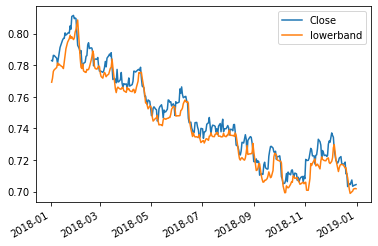

In [233]:
AUDUSD[['Close', 'lowerband']]['2018'].plot()

In [247]:
bt = Backtest(AUDUSD, SmaCross)

bt.run()
bt.plot()

C:\Users\tempurak\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Superimposed OHLC plot matches the original plot. Skipping.
  after removing the cwd from sys.path.
